In [1]:
# Packages

In [2]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.cross_validation import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline 

import math
from nltk import tokenize

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Merge, Dropout, LSTM, GRU, Bidirectional, TimeDistributed
from keras.models import Model

from keras import backend as K
from keras.engine.topology import Layer, InputSpec


import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))


Using TensorFlow backend.


# Data handling

## Load data

In [3]:
#LOAD DATA
print("Loading data...")
train = pd.read_table("../../dat/train.tsv")
test = pd.read_table("../../dat/test.tsv")
print('Data loaded')
print(train.shape)
print(test.shape)


Loading data...
Data loaded
(1482535, 8)
(693359, 7)


## Handle missing values

In [4]:
#HANDLE MISSING VALUES
print("Handling missing values...")
def handle_missing(dataset):
    dataset.category_name.fillna(value="missing", inplace=True)
    dataset.brand_name.fillna(value="missing", inplace=True)
    dataset.item_description.fillna(value="missing", inplace=True)
    return (dataset)

train = handle_missing(train)
test = handle_missing(test)
print(train.shape)
print(test.shape)

Handling missing values...
(1482535, 8)
(693359, 7)


In [5]:
train.head(3)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,missing,10,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10,1,Adorable top with a hint of lace and a key hol...


## Handle categorial features

In [6]:
#PROCESS CATEGORICAL DATA
print("Handling categorical variables...")
le = LabelEncoder()

le.fit(np.hstack([train.category_name, test.category_name]))
train.category_name = le.transform(train.category_name)
test.category_name = le.transform(test.category_name)

le.fit(np.hstack([train.brand_name, test.brand_name]))
train.brand_name = le.transform(train.brand_name)
test.brand_name = le.transform(test.brand_name)
del le

train.head(3)

Handling categorical variables...


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,829,5265,10,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,86,3889,52,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,1277,4588,10,1,Adorable top with a hint of lace and a key hol...


## Handle text features

In [7]:
#PROCESS TEXT: RAW
print("Text to seq process...")
from keras.preprocessing.text import Tokenizer
raw_text = np.hstack([train.item_description.str.lower(), train.name.str.lower()])
print("   Transforming text to seq of sentences, which is a sequence of words...")
print("   Fitting tokenizer...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(raw_text)
word_index = tokenizer.word_index
print('Total %s unique tokens.' % len(word_index))

Text to seq process...
   Transforming text to seq of sentences, which is a sequence of words...
   Fitting tokenizer...
Total 259198 unique tokens.


In [8]:

MAX_SENTS = 5
MAX_SENT_LENGTH = 25
MAX_NB_WORDS = 20000
def process_hierarichal_text(descriptions_raw):
    descriptions = []
    for description in descriptions_raw:
        
        sentences = tokenize.sent_tokenize(description.decode('utf8'))        
        #sentences = tokenize.sent_tokenize(description)
        
        '''
        MAX_SENTS = max(MAX_SENTS, len(sentences))
        for sent in sentences:
            MAX_SENT_LENGTH = max(MAX_SENT_LENGTH, len(tok_raw.texts_to_sequences(sent)))
        '''
        descriptions.append(sentences)
    #print('MAX_SENTS = ', MAX_SENTS)
    #print('MAX_SENT_LENGTH = ', MAX_SENT_LENGTH)

    data = np.zeros((len(descriptions_raw), MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')
    #n_errs = 0
    for i, description in enumerate(descriptions):
        sent_words_indices = tokenizer.texts_to_sequences(description)
        for j in range(len(sent_words_indices)):
            if j< MAX_SENTS:
                for k in range(len(sent_words_indices[j])):
                    word_idx = sent_words_indices[j][k]
                    if k < MAX_SENT_LENGTH and word_idx < MAX_NB_WORDS:
                        data[i,j,k] = word_idx
                        #print(data[i,j,k])
                    
    #print('Total errors=', n_errs)
    #print(data)
    return data
    

In [9]:
print('Total %s unique tokens.' % len(word_index))

train_seq_item_desc = process_hierarichal_text(train.item_description.str.lower())
test_seq_item_desc = process_hierarichal_text(test.item_description.str.lower())
 
train["seq_item_description"] = list(train_seq_item_desc)
test["seq_item_description"] = list(test_seq_item_desc)


Total 259198 unique tokens.


In [10]:
train["seq_name"] = tokenizer.texts_to_sequences(train.name.str.lower())
test["seq_name"] = tokenizer.texts_to_sequences(test.name.str.lower())
train.head(3)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,seq_item_description,seq_name
0,0,MLB Cincinnati Reds T Shirt Size XL,3,829,5265,10,1,No description yet,"[[12, 68, 79, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[3851, 8822, 6896, 208, 84, 6, 155]"
1,1,Razer BlackWidow Chroma Keyboard,3,86,3889,52,0,This keyboard is in great condition and works ...,"[[29, 2627, 10, 7, 39, 17, 1, 207, 51, 19, 111...","[10759, 25570, 16366, 2627]"
2,2,AVA-VIV Blouse,1,1277,4588,10,1,Adorable top with a hint of lace and a key hol...,"[[604, 60, 9, 4, 5347, 11, 192, 1, 4, 886, 129...","[7634, 10563, 666]"


### Embeddings

### Embeddings size calculations

In [11]:
#SEQUENCES VARIABLES ANALYSIS
max_name_seq = np.max([np.max(train.seq_name.apply(lambda x: len(x))), np.max(test.seq_name.apply(lambda x: len(x)))])
max_seq_item_description = np.max([np.max(train.seq_item_description.apply(lambda x: len(x)))
                                   , np.max(test.seq_item_description.apply(lambda x: len(x)))])
print("max name seq "+str(max_name_seq))
print("max item desc seq "+str(max_seq_item_description))

max name seq 17
max item desc seq 5


In [12]:
#EMBEDDINGS MAX VALUE
#Base on the histograms, we select the next lengths
MAX_NAME_SEQ = 10
#MAX_ITEM_DESC_SEQ = 75
MAX_TEXT = np.max([np.max(train.seq_name.max())
                   , np.max(test.seq_name.max())])+2
MAX_CATEGORY = np.max([train.category_name.max(), test.category_name.max()])+1
MAX_BRAND = np.max([train.brand_name.max(), test.brand_name.max()])+1
MAX_CONDITION = np.max([train.item_condition_id.max(), test.item_condition_id.max()])+1

## Pre-trained embeddings

### Glove


In [13]:
def get_embeddings_matrix(embedding_dim):
    import os    
    GLOVE_DIR = "../../dat/glove"
    embeddings_index = {}
    f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

    f.close()

    print('Total %s word vectors.' % len(embeddings_index))    
    embedding_matrix = np.random.random((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            #print(i, ' ', embedding_vector.shape)
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

## Target formatting

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc4d3fe9310>]], dtype=object)

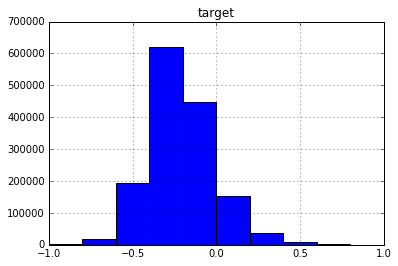

In [14]:
#SCALE target variable
train["target"] = np.log(train.price+1)
target_scaler = MinMaxScaler(feature_range=(-1, 1))
train["target"] = target_scaler.fit_transform(train.target.reshape(-1,1))
pd.DataFrame(train.target).hist()

## Train/Val split

In [15]:
#EXTRACT DEVELOPTMENT TEST
dtrain, dvalid = train_test_split(train, random_state=123, train_size=0.99)
print(dtrain.shape)
print(dvalid.shape)

(1467709, 11)
(14826, 11)


In [16]:
#KERAS DATA DEFINITION
from keras.preprocessing.sequence import pad_sequences

def get_keras_data(dataset):
    seq_item_description_data = np.reshape(list(dataset.seq_item_description), [len(dataset.seq_item_description), MAX_SENTS,MAX_SENT_LENGTH])
    X = {
        'name': pad_sequences(dataset.seq_name, maxlen=MAX_NAME_SEQ)
        ,'item_desc': seq_item_description_data
        ,'brand_name': np.array(dataset.brand_name)
        ,'category_name': np.array(dataset.category_name)
        ,'item_condition': np.array(dataset.item_condition_id)
        ,'num_vars': np.array(dataset[["shipping"]])
    }
    return X

X_train = get_keras_data(dtrain)
X_valid = get_keras_data(dvalid)
X_test = get_keras_data(test)

# Model

In [17]:
#KERAS MODEL DEFINITION
from keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten, BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import backend as K

def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

def rmsle_cust(y_true, y_pred):
    first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
    return K.sqrt(K.mean(K.square(first_log - second_log), axis=-1))

def get_HATT_representation(item_desc_input_layer):
    
    # building Hierachical Attention network
    EMBEDDING_DIM = 100
    # Pre-trained Embeddings
    embedding_matrix = get_embeddings_matrix(embedding_dim=EMBEDDING_DIM)
    
    embedding_layer = Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SENT_LENGTH,
                                trainable=True)
    
    # Attention
    from keras.engine.topology import Layer
    from keras import initializers
    from keras import backend as K
    import tensorflow as tf
    class AttLayer(Layer):
        def __init__(self, **kwargs):
            self.init = initializers.VarianceScaling(scale=1.0, mode='fan_in', distribution='normal', seed=None)
            super(AttLayer, self).__init__(**kwargs)

        def build(self, input_shape):
            assert len(input_shape)==3
            self.W = K.variable((self.init((input_shape[-1],1))))
            self.trainable_weights = [self.W]
            super(AttLayer, self).build(input_shape)  # be sure you call this somewhere!

        def call(self, x, mask=None):
            eij = K.tanh(K.dot(x, self.W))

            ai = K.exp(eij)
            weights = ai/tf.expand_dims(K.sum(ai, axis=1), 1)

            weighted_input = x*weights
            return tf.reduce_sum(weighted_input, axis=1)

        def compute_output_shape(self, input_shape):
            return (input_shape[0], input_shape[-1])


    
    # HATT model
    sentence_input = Input(shape=(MAX_SENT_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sentence_input)

    l_lstm = Bidirectional(GRU(16, return_sequences=True))(embedded_sequences)
    l_dense = TimeDistributed(Dense(20))(l_lstm)
    l_att = AttLayer()(l_dense)
    sentEncoder = Model(sentence_input, l_att)
    
    '''
    l_lstm = Bidirectional(LSTM(100))(embedded_sequences)
    sentEncoder = Model(sentence_input, l_lstm)
    '''

    #review_input = Input(shape=(MAX_SENTS,MAX_SENT_LENGTH), dtype='int32')
    review_encoder = TimeDistributed(sentEncoder)(item_desc_input_layer)

    '''
    l_lstm_sent = Bidirectional(LSTM(100))(review_encoder)
    '''

    
    l_lstm_sent = Bidirectional(GRU(8, return_sequences=True))(review_encoder)
    l_dense_sent = TimeDistributed(Dense(20))(l_lstm_sent)
    l_att_sent = AttLayer()(l_dense_sent)
    
    return l_att_sent
    #return l_lstm_sent

def get_model():
    #params
    dr_r = 0.1
    
    #Inputs
    name = Input(shape=[X_train["name"].shape[1]], name="name")
    
    item_desc = Input(shape=[MAX_SENTS, MAX_SENT_LENGTH], name="item_desc")
    brand_name = Input(shape=[1], name="brand_name")
    category_name = Input(shape=[1], name="category_name")
    item_condition = Input(shape=[1], name="item_condition")
    num_vars = Input(shape=[X_train["num_vars"].shape[1]], name="num_vars")
    
    #Embeddings layers
    emb_name = Embedding(MAX_TEXT, 50)(name)
    #emb_item_desc = Embedding(MAX_TEXT, 50)(item_desc)
    emb_brand_name = Embedding(MAX_BRAND, 10)(brand_name)
    emb_category_name = Embedding(MAX_CATEGORY, 10)(category_name)
    emb_item_condition = Embedding(MAX_CONDITION, 5)(item_condition)
    
    #rnn layer
    HATT_layer = get_HATT_representation(item_desc)
    rnn_layer2 = GRU(8) (emb_name)
    
    #main layer
    
    main_l = concatenate([
        Flatten() (emb_brand_name)
        , Flatten() (emb_category_name)
        , Flatten() (emb_item_condition)
        , HATT_layer
        , rnn_layer2
        #, num_vars
    ])
    
    #main_l = num_vars
    main_l = Dropout(dr_r) (Dense(128) (main_l))
    main_l = Dropout(dr_r) (Dense(64) (main_l))
    
    #output
    output = Dense(1, activation="linear") (main_l)
    
    #model
    import keras.optimizers
    lr = 0.01
    opt = keras.optimizers.adagrad(lr)
    model = Model([name, item_desc, brand_name
                   , category_name, item_condition, num_vars], output)
    model.compile(loss="mse", optimizer=opt, metrics=["mae", rmsle_cust])
    
    return model

    
model = get_model()
model.summary()
'''
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
'''

Total 7396 word vectors.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
item_desc (InputLayer)          (None, 5, 25)        0                                            
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 5, 20)        25931812    item_desc[0][0]                  
__________________________________________________________________________________________________
brand_name (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
category_name (InputLayer)      (None, 1)            0                                            
____________________________________________________________________________________

"\nfrom keras.utils.vis_utils import plot_model\nplot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)\n"

# Train/fit

In [18]:
#FITTING THE MODEL
BATCH_SIZE = 20000
epochs = 5

model = get_model()
model.fit(X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
          , validation_data=(X_valid, dvalid.target)
          , verbose=1)

Total 7396 word vectors.
Train on 1467709 samples, validate on 14826 samples
Epoch 1/5
1467709/1467709 [==============================] - 47s 32us/step - loss: 0.3240 - mean_absolute_error: 0.2572 - rmsle_cust: 0.0358 - val_loss: 0.0275 - val_mean_absolute_error: 0.1285 - val_rmsle_cust: 0.0159
Epoch 2/5
1467709/1467709 [==============================] - 44s 30us/step - loss: 0.0302 - mean_absolute_error: 0.1347 - rmsle_cust: 0.0161 - val_loss: 0.0214 - val_mean_absolute_error: 0.1120 - val_rmsle_cust: 0.0142
Epoch 3/5
1467709/1467709 [==============================] - 44s 30us/step - loss: 0.0247 - mean_absolute_error: 0.1212 - rmsle_cust: 0.0151 - val_loss: 0.0202 - val_mean_absolute_error: 0.1083 - val_rmsle_cust: 0.0138
Epoch 4/5
1467709/1467709 [==============================] - 44s 30us/step - loss: 0.0222 - mean_absolute_error: 0.1145 - rmsle_cust: 0.0144 - val_loss: 0.0195 - val_mean_absolute_error: 0.1063 - val_rmsle_cust: 0.0136
Epoch 5/5
1467709/1467709 [====================

## KFold (TODO)

# Evaulate

In [19]:
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(to_sum) * (1.0/len(y))) ** 0.5
#Source: https://www.kaggle.com/marknagelberg/rmsle-function

In [23]:
#EVLUEATE THE MODEL ON DEV TEST: What is it doing?
val_preds = model.predict(X_valid)
val_preds = target_scaler.inverse_transform(val_preds)
val_preds = np.exp(val_preds)+1

#mean_absolute_error, mean_squared_log_error
y_true = np.array(dvalid.price.values)
y_pred = val_preds[:,0]
v_rmsle = rmsle(y_true, y_pred)
print(" RMSLE error on dev test: "+str(v_rmsle))

 RMSLE error on dev test: 0.539568807151


# Submit

In [21]:
#CREATE PREDICTIONS
preds = model.predict(X_test, batch_size=BATCH_SIZE)
preds = target_scaler.inverse_transform(preds)
preds = np.exp(preds)-1

submission = test[["test_id"]]
submission["price"] = preds

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


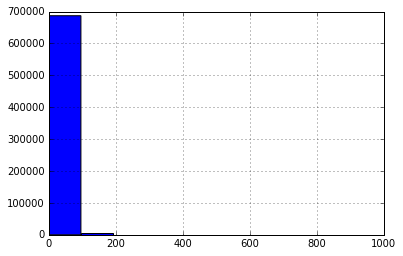

In [22]:
submission.to_csv("./myNNsubmission.csv", index=False)
submission.price.hist()

# Reference


https://www.kaggle.com/knowledgegrappler/a-simple-nn-solution-with-keras-0-48611-pl